## S2DS gophr -  EDA Felix

In [1]:
# import pkgs
%load_ext autoreload
%autoreload 2
import utils
import numpy as np
import pandas as pd
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', color_codes = True)
sns.set_context("notebook", font_scale = 1.1)
plt.rcParams['savefig.dpi'] = 800
plt.rcParams['figure.figsize'] = 12, 8
%config InlineBackend.figure_format = "retina"

import data
import features

In [ ]:
# query database and save data as DataFrame
data.execute_query_and_save_df('df1_query.sql', 'df1.feather')
data.execute_query_and_save_df('weather_query.sql', 'weather_df.feather')

Opening database connection
Querying database with query in /Users/felixschrank/Dropbox/S2DS/s2ds/src/data/df1_query.sql


In [2]:
# read, clean, merge and save the data
#df = data.clean_merge_and_save('df1.feather',
#                          'weather_df.feather', 'df_concat.feather')
# load the data
df = pd.read_feather(utils.path_to('data', 'interim', 'df_clean.feather'))
df, feature_names  = features.generate_features(df)

Timed categorising: earliest_pickup_time
Timed categorising: delivery_deadline
Unchanged features: show_on_board, is_first_war_job, temp, feels_like, humidity, wind_speed, clouds_all, is_daytime
Engineering individual features
Log transforming: distance, initial_time_buffer, estimated_journey_time, courier_earnings_calc, size_min, size_med, size_max, weight, volume, size_min_max
Minimum of initial_time_buffer is less or equal to 0: -12839.0, adding constant of 12840.0 prior to log.
Minimum of courier_earnings_calc is less or equal to 0: -5904.46, adding constant of 5905.46 prior to log.
One hot encoding: is_food, is_fragile, is_liquid, is_not_rotatable, is_glass, is_baked, is_flower, is_alcohol, is_beef, is_pork
One hot encoding: vehicle_type, job_priority, weather_cats, earliest_pickup_time_month, earliest_pickup_time_day, earliest_pickup_time_hour, pickup_zone, delivery_zone
Cyclic encoding: earliest_pickup_time
Cyclic encoding: delivery_deadline


In [7]:
# General overview
print(df.info())
print('\nMissing values:\n')
print(df.isna().sum())
print('\nShape:\n')
print(df.shape)
print('\nDescribe:\n')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138945 entries, 0 to 138944
Columns: 109 entries, show_on_board to delivery_deadline_day_cos
dtypes: bool(3), float64(20), int64(86)
memory usage: 112.8 MB
None

Missing values:

show_on_board                    0
is_first_war_job                 0
temp                             0
feels_like                       0
humidity                         0
wind_speed                       0
clouds_all                       0
is_daytime                       0
initial_time_buffer              0
is_morning_job                   0
is_evening_job                   0
is_scheduled_job                 0
distance_log                     0
courier_money_earned_net_log     0
size_min_log                     0
size_med_log                     0
size_max_log                     0
weight_log                       0
volume_log                       0
size_min_max_log                 0
is_food_1                        0
is_food_99                       0
i

In [9]:
# How many jobs are accepted?
print('{:03.1f}% are hard jobs.'.format(100*df['is_hard'].sum() / df['is_hard'].count()))

7.5% are hard jobs.


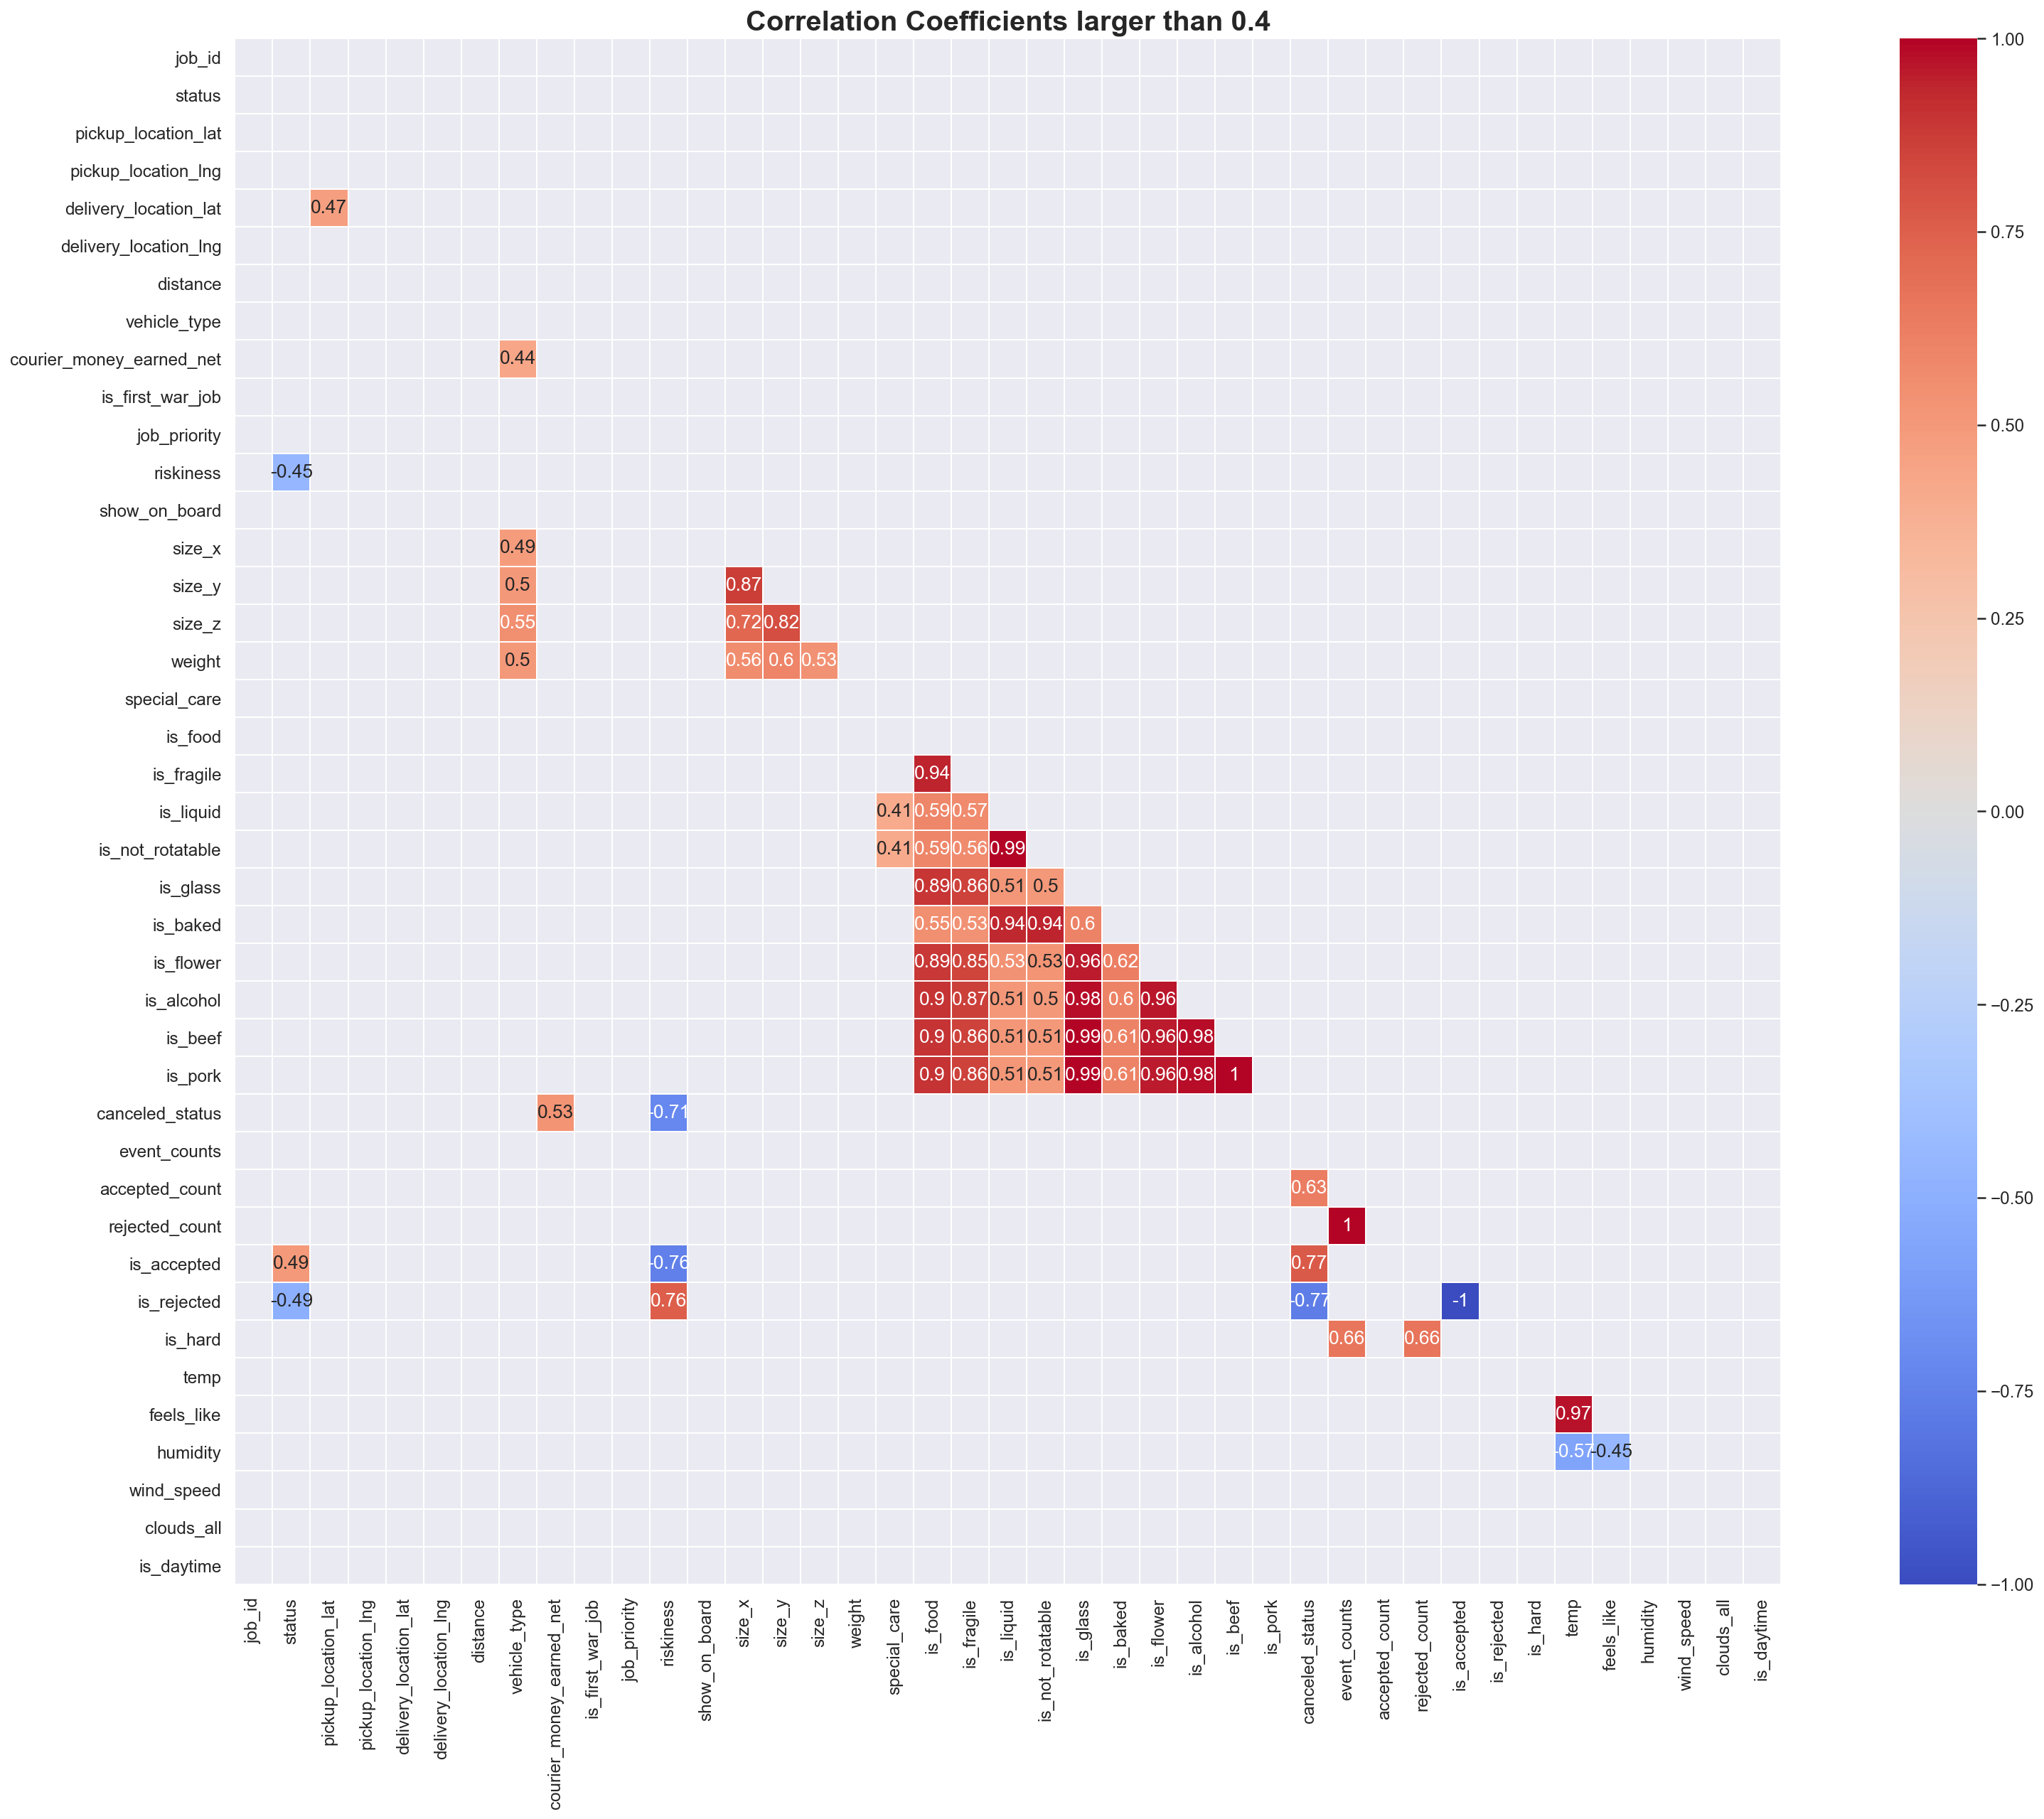

In [11]:
# Overview correlation analysis
df_corr = df.corr()

# mask for the upper triangle
mask = np.zeros_like(df_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Thresholding correlations
df_corr[np.abs(df_corr) < 0.4] = None

# figure
df_corr.style.background_gradient().set_precision(2)
plt.figure(figsize = (30, 20))
ax = plt.axes()
sns.heatmap(df_corr, mask = mask, cmap = 'coolwarm', annot = True, center = 0, square = True, linewidths = 0.5, ax = ax)
ax.set_title('Correlation Coefficients larger than 0.4', fontweight = "bold", fontsize = 20)
plt.show()

### Distance

max       51.175000
min        0.001000
mean       5.888191
median     4.809000
Name: distance, dtype: float64

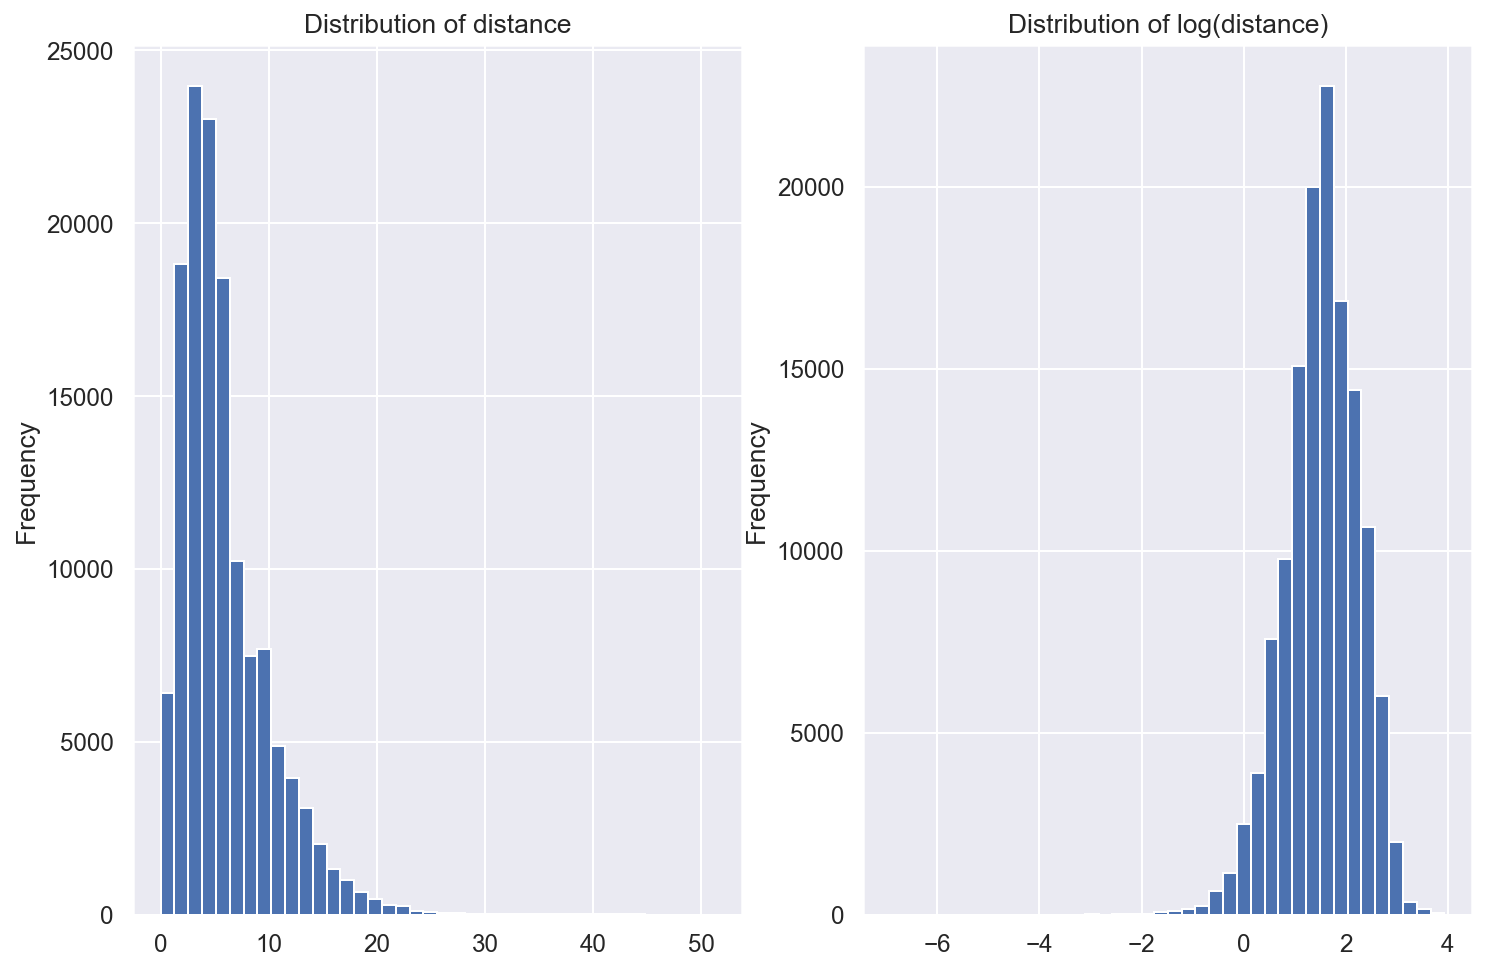

In [14]:
# Summary statistics of distance
display(df['distance'].agg([max, min, np.mean, np.median]))

# Log transformation of distance
df['distance_log'] = np.log(df['distance'])

fig, axs = plt.subplots(1, 2)
df['distance'].plot(bins=40, ax= axs[0], kind='hist',title='Distribution of distance')
df['distance_log'].plot(bins=40, ax= axs[1], kind='hist',title='Distribution of log(distance)')
plt.show()

### Weight and sizes

             weight      size_x      size_y     size_z           vol
max     1140.000000  450.000000  250.000000  250.00000  1.562500e+07
min        0.012000    1.000000    1.000000    0.50000  1.000000e+00
mean       6.675373   38.381118   27.746925   15.99013  4.540914e+04
median     1.500000   35.000000   25.000000   15.00000  1.125000e+04


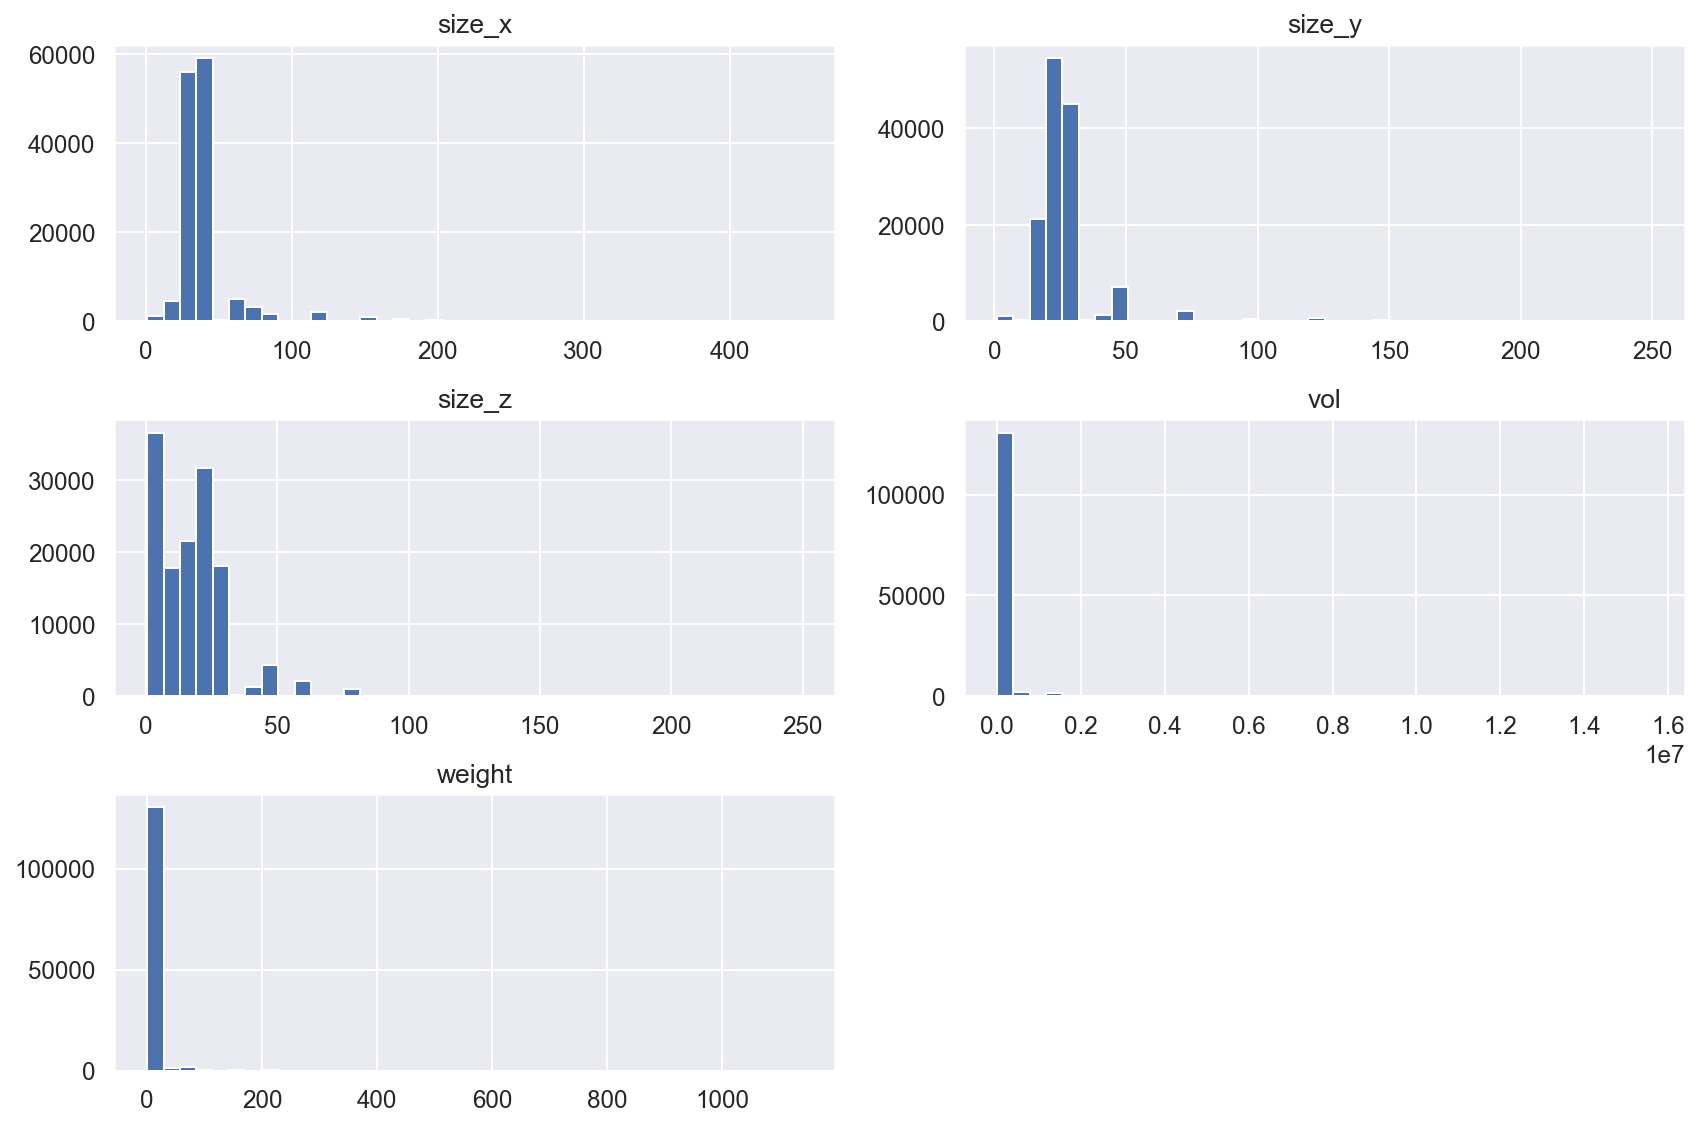

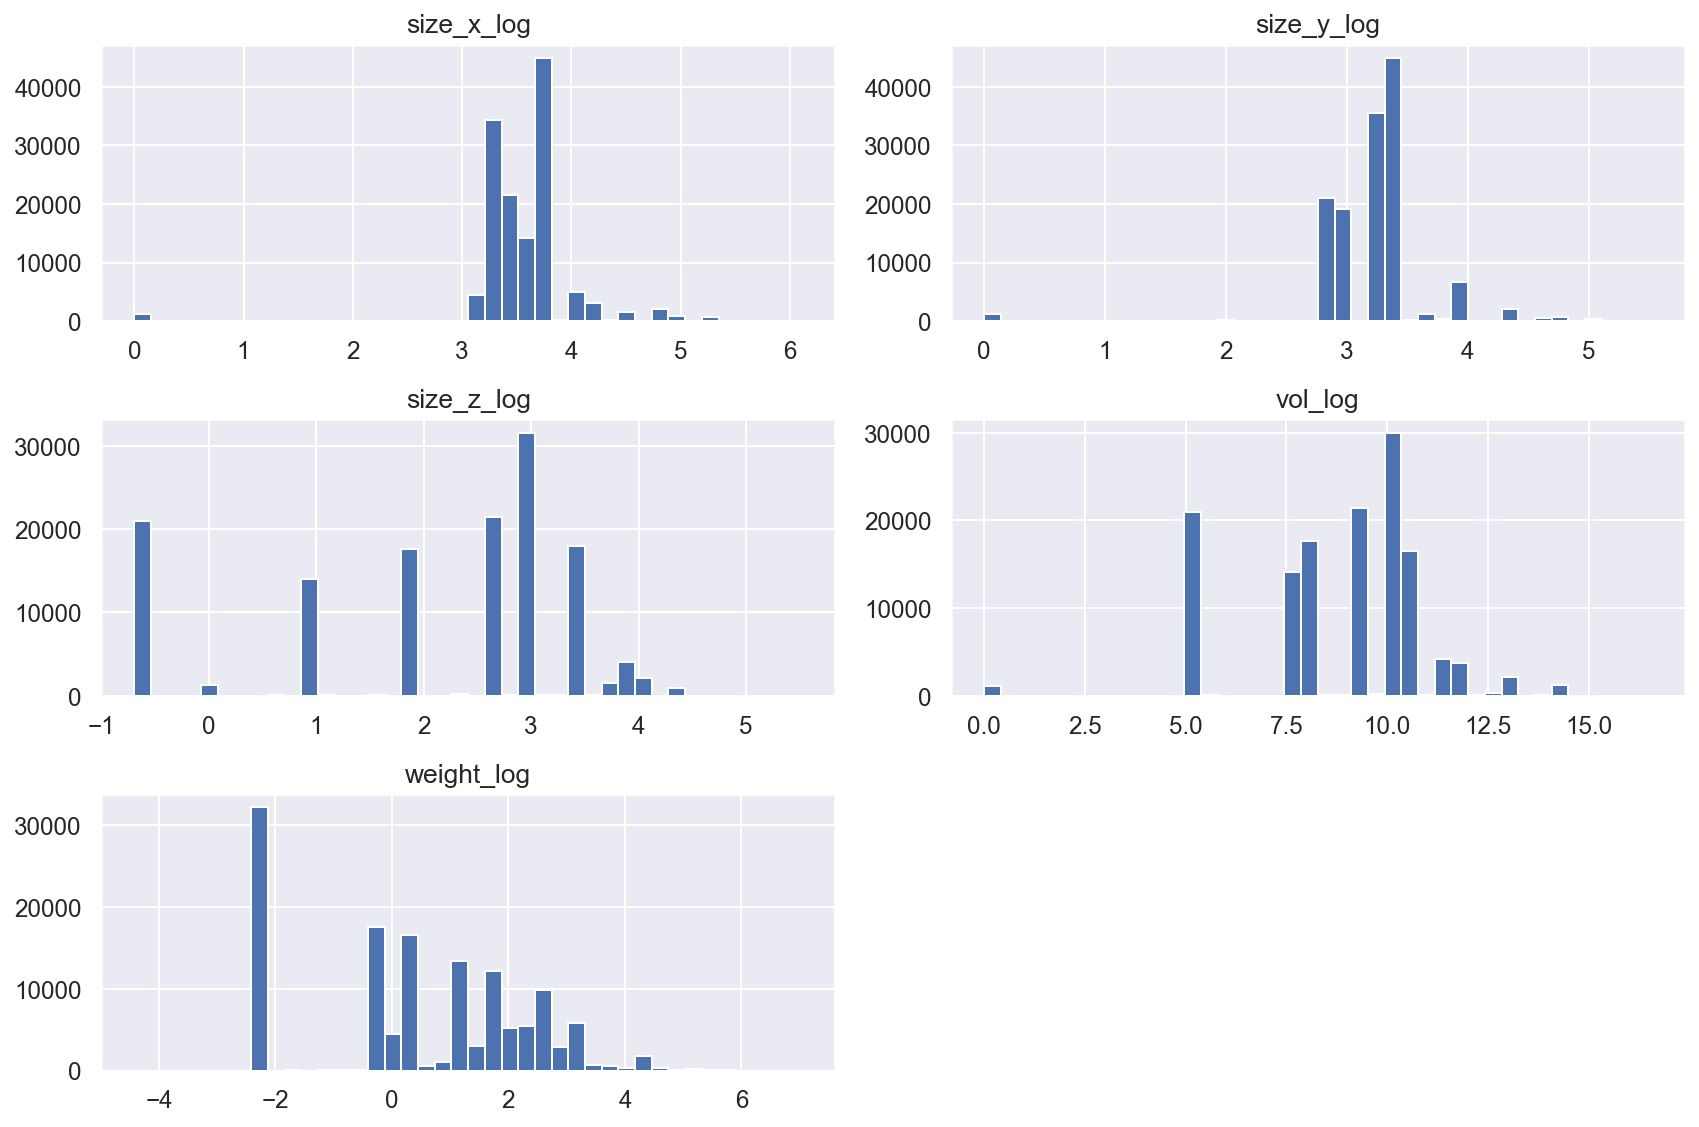

In [15]:
df['weight'].dropna(inplace=True)
df['vol'] = df['size_x'] * df['size_y'] * df['size_z']
print(df[['weight','size_x','size_y','size_z','vol']].agg([max, min, np.mean, np.median]))

# true values
df[['weight','size_x','size_y','size_z', 'vol']].hist(bins = 40)
plt.tight_layout()

# log transform
df['weight_log'] = np.log(df['weight'])
df['size_x_log'] = np.log(df['size_x'])
df['size_y_log'] = np.log(df['size_y'])
df['size_z_log'] = np.log(df['size_z'])
df['vol_log'] = np.log(df['vol'])

df[['weight_log','size_x_log','size_y_log','size_z_log','vol_log']].hist(bins = 40)
plt.tight_layout()

### Vehicle_type

Text(0.5, 1.0, 'Number of rejected in %')

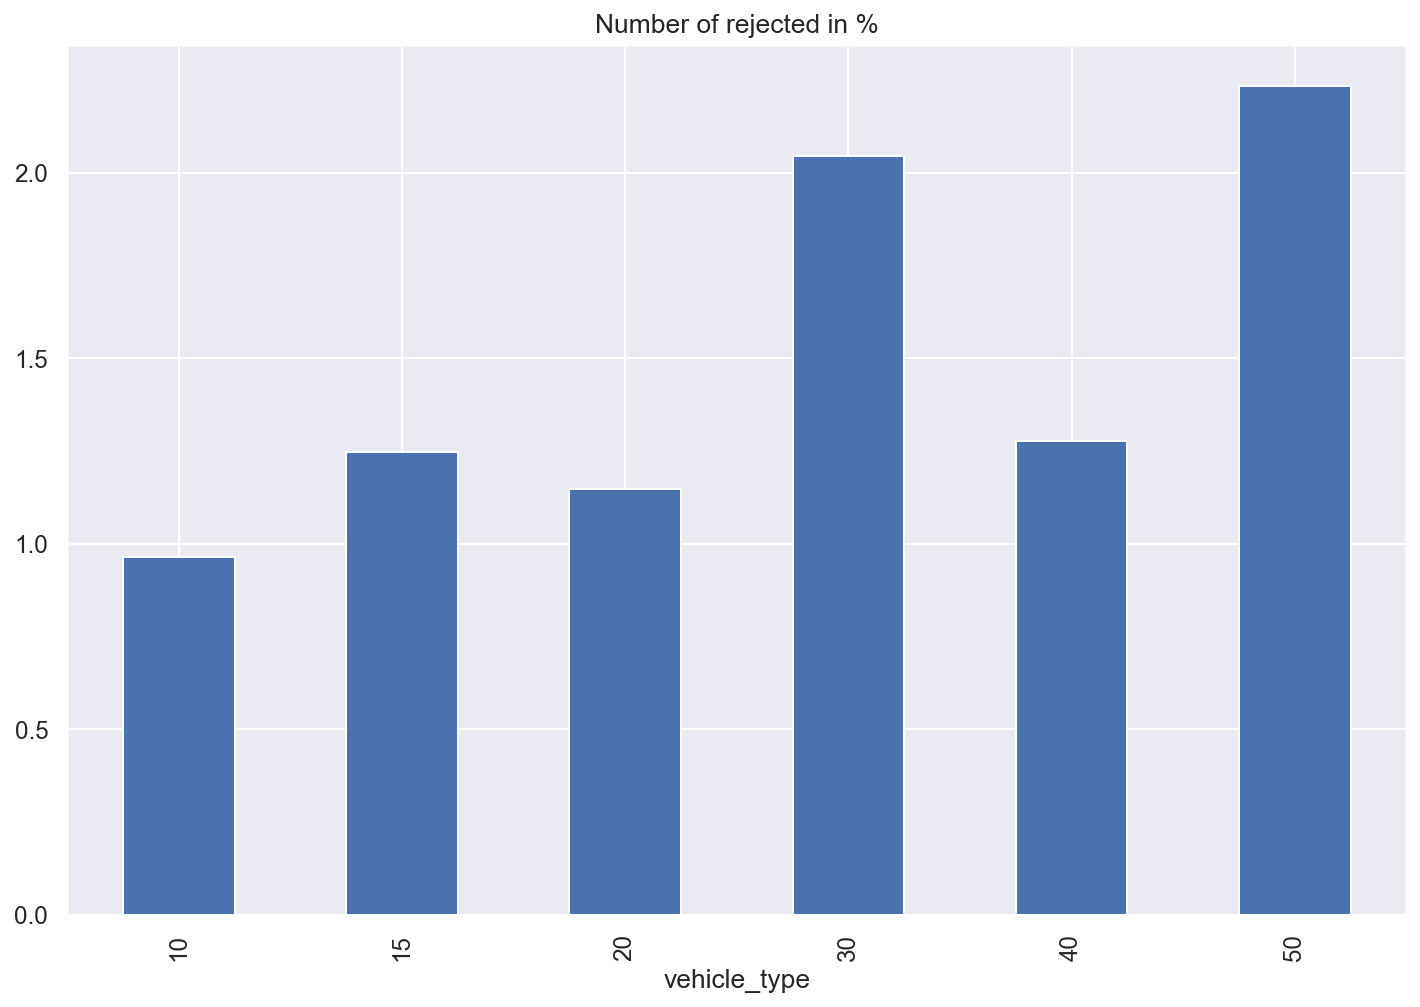

In [17]:
df_vehicle_type = df.groupby('vehicle_type')['is_accepted'].agg(['sum','count'])
df_vehicle_type['is_rejected_prop'] = 100*(1-(df_vehicle_type['sum'] / df_vehicle_type['count']))

df_vehicle_type['is_rejected_prop'].plot(kind='bar')
plt.title('Number of rejected in %')

### Why are jobs rejected?

In [12]:
df.groupby('is_hard').agg([min, max, np.median])

job_id                 status            pickup_location_lat  \
            min     max  median    min max median                 min   
is_hard                                                                 
0        231558  831742  508577     80  99     99           51.389159   
1        231626  828158  526320     80  99     99           51.392657   

                              pickup_location_lng                      \
               max     median                 min       max    median   
is_hard                                                                 
0        51.649471  51.519083           -0.346248  0.124983 -0.136523   
1        51.641777  51.515927           -0.316636  0.092690 -0.113547   

        delivery_location_lat                       delivery_location_lng  \
                          min        max     median                   min   
is_hard                                                                     
0                   51.383377  51.648866  51.517685             -0.343741   
1                   51.396416  51.643303  51.515525             -0.366133   

                            distance                vehicle_type             \
              max    median      min     max median          min max median   
is_hard                                                                       
0        0.137254 -0.132486    0.001  51.175  4.835           10  50     20   
1        0.108882 -0.120093    0.156  36.672  4.538           10  50     20   

        courier_money_earned_net                is_first_war_job             \
                             min     max median              min max median   
is_hard                                                                       
0                          -0.14  220.02   7.48                0   0      0   
1                          -0.11  140.00   6.54                0   0      0   

         ... accepted_count            rejected_count             is_accepted  \
         ...            min max median            min  max median         min   
is_hard  ...                                                                    
0        ...              0   8      1              0    4      0           0   
1        ...              0   5      1              5  191      8           0   

                   is_rejected             temp               feels_like  \
        max median         min max median   min    max median        min   
is_hard                                                                    
0         1      1           0   1      0 -5.01  33.52  13.12     -15.07   
1         1      1           0   1      0 -5.01  33.37  11.74     -13.93   

                      humidity             wind_speed              clouds_all  \
           max median      min  max median        min   max median        min   
is_hard                                                                         
0        31.05   9.23       21  100     64       0.47  17.5   4.60          0   
1        30.98   7.33       21  100     67       0.47  17.5   4.63          0   

                    is_daytime             
         max median        min max median  
is_hard                                    
0        100     75          0   1      1  
1        100     75          0   1      1  

[2 rows x 120 columns]

In [25]:
# bool if pickup_postcode and delivery_postcode the same
df['same_post_code'] = (df['pickup_postcode_outer'] == df['delivery_postcode_outer'])
# compute avg acceptance for same_post_code
test = df.groupby('same_post_code')['is_accepted'].agg(['sum', 'count'])
test['avg_acceptance'] = test['sum'] / test['count']
test['avg_acceptance'] 

same_post_code
False    0.987417
True     0.992775
Name: avg_acceptance, dtype: float64

In [26]:
# bool if pickup_postcode and delivery_postcode the same
df['same_post_code'] = (df['pickup_postcode_inner'] == df['delivery_postcode_inner'])
# compute avg acceptance for same_post_code
test = df.groupby('same_post_code')['is_accepted'].agg(['sum', 'count'])
test['avg_acceptance'] = test['sum'] / test['count']
test['avg_acceptance'] 

same_post_code
False    0.987691
True     0.970732
Name: avg_acceptance, dtype: float64

## weather data

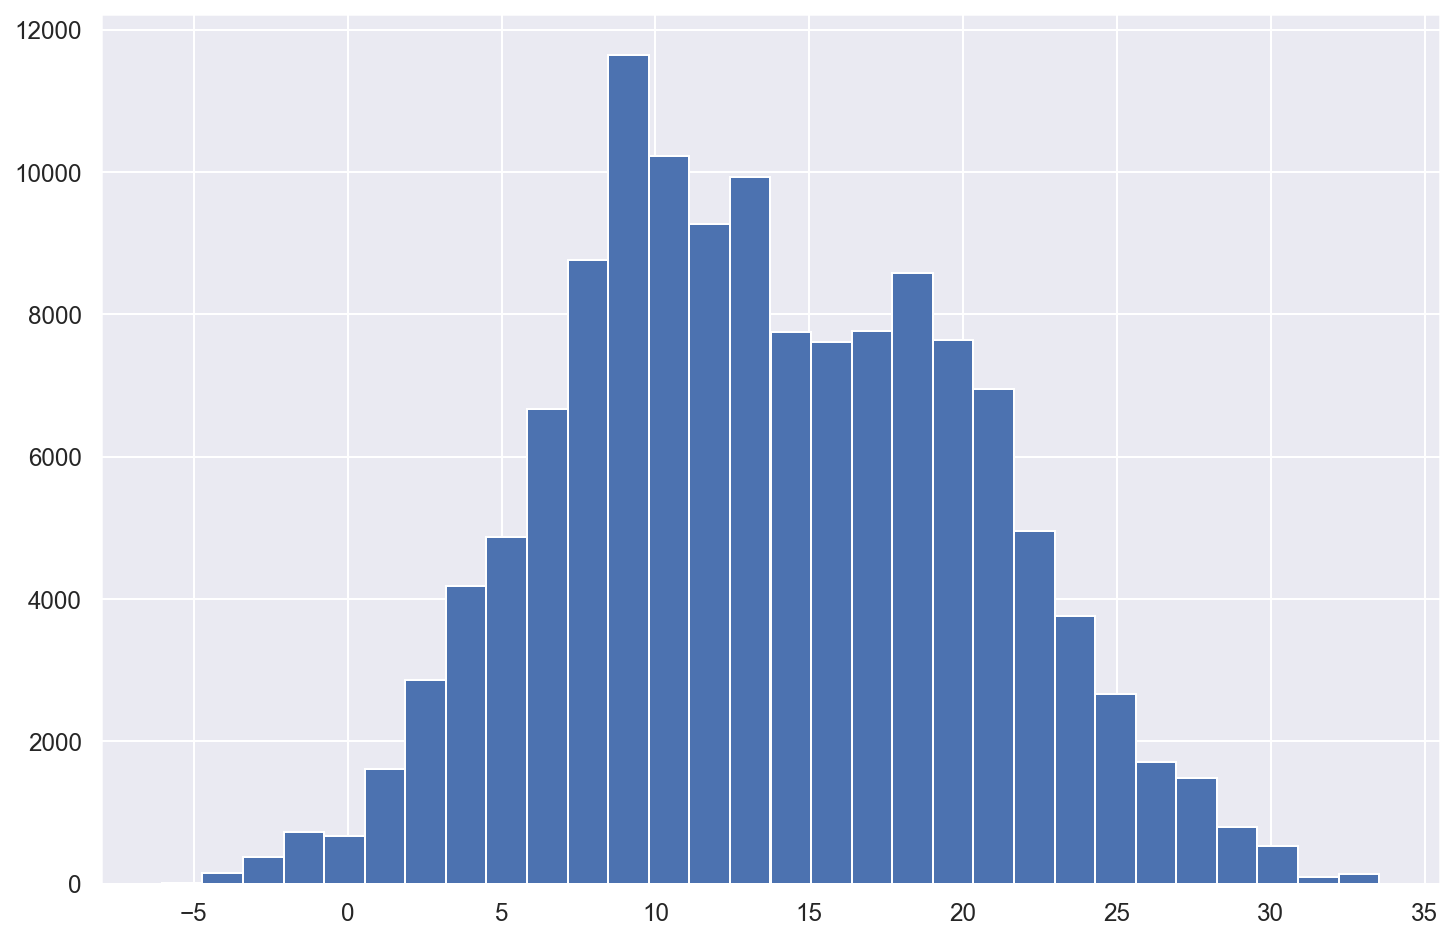

In [37]:
df['temp'].hist(bins=30)
plt.show()

## DBSCAN

In [3]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [67]:
# get data
coords = df[['delivery_location_lat','delivery_location_lng']].values
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian

db = DBSCAN(eps=epsilon, 
            min_samples=2000, 
            algorithm='ball_tree', 
            metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 3


In [84]:
#h = ax.scatter(dfm.iloc[:,1]*10e2,
#               dfm.iloc[:,0]*10e2, c=dfm.iloc[:,2], cmap='magma', alpha=0.6, s=dfm.iloc[:,2]**(1.8))